<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, recall_score, mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, precision_score, f1_score, precision_recall_curve
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
import re
from sklearn.preprocessing import OrdinalEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим файл в датафрейм, посмотрим его размерность и выведем несколько строк для наглядности данных. Немного изменим написание названия столбцов для бОльшей читаемости.

Так как я работаю локально, потренировалась в загрузке датасета напрямую из kaggle: 

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.columns = [re.sub(r"\B([A-Z])", r"_\1", col).lower() for col in df.columns]

display(df.shape)
display(df.sample(3))

(10000, 14)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
5860,5861,15723818,Carpenter,453,France,Female,37,4.0,131834.76,2,1,0,8949.20,0
9959,9960,15677783,Graham,764,Spain,Male,38,4.0,113607.47,1,1,0,91094.46,0
8019,8020,15771154,North,683,France,Female,73,8.0,137732.23,2,1,1,133210.44,0



Посмотрим информацию по выборке: 
* тип данных `dtypes`, 
* наличие дубликатов `dupl_cnt`, 
* пропусков `count`, 
* уникальные значения `nunique`и другие статистические метрики.

На локальной машине можно запустить `pandas_profiling` -- полная информация о датафрейме.

In [3]:
def describe_full(df):
    return (df.describe(include='all', percentiles = [.5, .75, .9]).round(decimals = 2)
                                  .append(pd.Series(df.dtypes, name='dtypes'))
                                  .append(pd.Series(df[df.duplicated()].count(), name='dupl_cnt'))
                                  .append(pd.Series(df.nunique(axis = 0, dropna = True), name = 'nunique'))  
                                  .T)

In [4]:
describe_full(df)

,count,unique,top,freq,mean,std,min,50%,75%,90%,max,dtypes,dupl_cnt,nunique
row_number,10000.0,NaN,NaN,NaN,5000.5,2886.9,1.0,5000.5,7500.25,9000.1,10000.0,int64,0,10000
customer_id,10000.0,NaN,NaN,NaN,15690940.57,71936.19,15565701.0,15690738.0,15753233.75,15790830.7,15815690.0,int64,0,10000
surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,2932
credit_score,10000.0,NaN,NaN,NaN,650.53,96.65,350.0,652.0,718.0,778.0,850.0,int64,0,460
geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,3
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,2
age,10000.0,NaN,NaN,NaN,38.92,10.49,18.0,37.0,44.0,53.0,92.0,int64,0,70
tenure,9091.0,NaN,NaN,NaN,5.0,2.89,0.0,5.0,7.0,9.0,10.0,float64,0,11
balance,10000.0,NaN,NaN,NaN,76485.89,62397.41,0.0,97198.54,127644.24,149244.79,250898.09,float64,0,6382
num_of_products,10000.0,NaN,NaN,NaN,1.53,0.58,1.0,1.0,2.0,2.0,4.0,int64,0,4


В нашем распоряжении 10k записей, каждый объект в наборе данных — информация о клиента банка, а именно:
- `row_number` — индекс строки в данных
- `customer_id` — уникальный идентификатор клиента
- `surname` — фамилия
- `credit_score` — кредитный рейтинг
- `geography` — страна проживания
- `gender` — пол
- `age` — возраст
- `tenure` — сколько лет человек является клиентом банка
- `balance` — баланс на счёте
- `num_of_products` — количество продуктов банка, используемых клиентом
- `has_cr_card` — наличие кредитной карты
- `is_active_member` — активность клиента
- `estimated_salary` — предполагаемая зарплата
- `exited` — факт ухода клиента

Есть категориальные признаки - фамилия и пол клиента, а так же страна проживания.
Есть пропуски в поле с количество лет `tenure`, дубликатов не обнаружено, есть поля, по которым необходимо поменять тип полей.

Поля с индексами строки и фамилией не являются важной информацией для предсказания оттока клиента из банка -- ими можно пренебречь. К тому же уникальным идентификатором клиента может быть индекс строки.

In [5]:
df = df.drop(['row_number', 'surname', 'customer_id'] , axis=1)

Пропуски по количеству времени присутствия Клиента в банке (`tenure`) заполним медианным значением по столбцу активности клиента методом `transform`.

In [6]:
df.loc[df['tenure'].isnull(), 'tenure'] = df.groupby('is_active_member')['tenure'].transform('mean')

Поменяем тип данных в столбцах на основе значений объекта в каждом столбце с помощью метода `convert_dtypes()`.

In [7]:
df = df.convert_dtypes()
df.dtypes

credit_score          Int64
geography            string
gender               string
age                   Int64
tenure              Float64
balance             Float64
num_of_products       Int64
has_cr_card           Int64
is_active_member      Int64
estimated_salary    Float64
exited                Int64
dtype: object

Как видим, страна и пол клиента теперь строковые переменные.

Заменим вещественный тип данных на целочисленный.

In [8]:
for i in ['tenure', 'balance', 'estimated_salary']:
    df[i] = df[i].astype('int')

## Исследование задачи

Посмотрим, какие параметры влиют больше всего на факт оттока из банка с помощью функции `corr()`. 

In [9]:
df.corr().style.background_gradient(cmap='coolwarm', 
                                    axis=None, 
                                    vmin=df.corr().min().min(), 
                                    vmax=df.corr().max().max()).set_precision(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000,-0.004,0.001,0.006,0.012,-0.005,0.026,-0.001,-0.027
age,-0.004,1.000,-0.014,0.028,-0.031,-0.012,0.085,-0.007,0.285
tenure,0.001,-0.014,1.000,-0.006,0.011,0.026,-0.047,0.009,-0.013
balance,0.006,0.028,-0.006,1.000,-0.304,-0.015,-0.010,0.013,0.119
num_of_products,0.012,-0.031,0.011,-0.304,1.000,0.003,0.010,0.014,-0.048
has_cr_card,-0.005,-0.012,0.026,-0.015,0.003,1.000,-0.012,-0.010,-0.007
is_active_member,0.026,0.085,-0.047,-0.010,0.010,-0.012,1.000,-0.011,-0.156
estimated_salary,-0.001,-0.007,0.009,0.013,0.014,-0.010,-0.011,1.000,0.012
exited,-0.027,0.285,-0.013,0.119,-0.048,-0.007,-0.156,0.012,1.000


На факт оттока клиента больше всего влияет его возраст, а также баланс счета. Интересно, что чем активнее клиент, тем выше вероятность его ухода. Можно объяснить это заинтересованностью клиента в выгодных условиях банковских услуг. Вероятно, чем больше клиент использует банковские услуги, тем больше сравнивает их уровень у конкурентов.

А еще хочется посмотреть аналитику `describe_full` в разрезе факта ухода клиента из банка (голубой цвет - клиент остался, красный - ушел).

In [10]:
def highlight(df_analyses):
    ret = pd.DataFrame("", index=df_analyses.index, columns=df_analyses.columns)
    ret.loc[df_analyses["count"] == 7963] = "background-color: #99bafe"
    ret.loc[df_analyses["count"] == 2037] = "background-color: #f6a789"
    return ret

(describe_full(df.query("exited == 1"))
     .append(describe_full(df.query("exited == 0")))
     .reset_index()
     .style.apply(highlight, axis=None))

,index,count,unique,top,freq,mean,std,min,50%,75%,90%,max,dtypes,dupl_cnt,nunique
0,credit_score,2037.000000,nan,nan,nan,645.350000,100.320000,350.000000,646.000000,716.000000,776.400000,850.000000,Int64,0,420
1,geography,2037,3,Germany,814,nan,nan,nan,nan,nan,nan,nan,string,0,3
2,gender,2037,2,Female,1139,nan,nan,nan,nan,nan,nan,nan,string,0,2
3,age,2037.000000,nan,nan,nan,44.840000,9.760000,18.000000,45.000000,51.000000,58.000000,84.000000,Int64,0,58
4,tenure,2037.000000,nan,nan,nan,4.880000,2.810000,0.000000,5.000000,7.000000,9.000000,10.000000,int64,0,11
5,balance,2037.000000,nan,nan,nan,91108.170000,58360.600000,0.000000,109349.000000,131433.000000,152080.000000,250898.000000,int64,0,1527
6,num_of_products,2037.000000,nan,nan,nan,1.480000,0.800000,1.000000,1.000000,2.000000,3.000000,4.000000,Int64,0,4
7,has_cr_card,2037.000000,nan,nan,nan,0.700000,0.460000,0.000000,1.000000,1.000000,1.000000,1.000000,Int64,0,2
8,is_active_member,2037.000000,nan,nan,nan,0.360000,0.480000,0.000000,0.000000,1.000000,1.000000,1.000000,Int64,0,2
9,estimated_salary,2037.000000,nan,nan,nan,101465.180000,57912.420000,11.000000,102460.000000,152422.000000,180168.800000,199808.000000,int64,0,2031


Оба типа клиента (по факту оттока) почти не отличаются количеством лет `tenure`, а также фактом наличия кредитной карты. Это также подтвеждается коррелацией признаков.

**Портрет пользователей, ушедших в отток**:
- большинство (90%) имеют кредитный скоринг более 770
- в оттоке в основном - женщины за 58 лет, проживающие в Германии
- в среднем были клиентами банка в течение 4.8 лет
- средний баланс на счету клиента - 91 тыс у.е., предполагаемая зп - 101 тыс у.е.
- большинство имеют около трех банковских продуктов

**Портрет оставшихся пользователей**:
- в большинстве случаев - французы до 50 лет с кредитным скорингом -- порядка 778
- в среднем являются клиентами банка около 5 лет
- средний баланс на счету клиента - 73 тыс у.е., предполагаемая зп - 100 тыс у.е.
- большинство имеют около двух банковских продуктов

## Борьба с дисбалансом

Как увидели выше, в датасете есть категориальные признаки (география клиента и его пол), которые необходимо преобразовать в численные. Например, методом порядкового кодирования `Ordinal Encoding`.

In [11]:
encoder = OrdinalEncoder()
df = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

Интересно посмотреть на отношение числа правильных ответов к размеру тестовой выборки (метрика `accuracy`). Для этого обучим модель решающего дерева и посчитаем значение метрики на валидационной выборке.

'Доля правильных ответов: 0.7816'

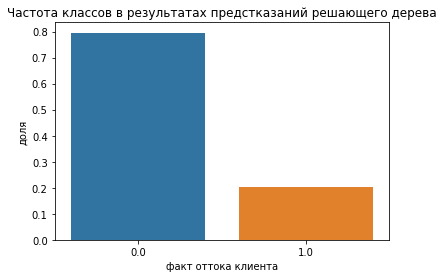

In [12]:
target = df['exited']
features = df.drop('exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model = DecisionTreeClassifier(random_state=12345, class_weight='balanced') # получите предсказания модели
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)

predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize = True)

display('Доля правильных ответов: %s' % accuracy_valid)

sns.barplot(class_frequency.index, class_frequency.values)
plt.xlabel('факт оттока клиента')
plt.ylabel('доля')
plt.title('Частота классов в результатах предстказаний решающего дерева')
plt.show()

По статистике (выше) 20.37% клиентов уходят в отток. Метрика `class_frequency` тоже ничего не изменила. Явно наблюдается дисбаланс классов, это плохо сказывается на обучении модели.

Наглядно представить результаты вычислений метрик точности и полноты позволяет матрица ошибок.

Напишем фукцию `metrics` для расчета метрик:
- **recall** (способность модели обнаруживать выборки, относящиеся к классу Positive);
- **precision** (классификация всех Positive семплов как Positive, не допуская ложных определений Negative как Positive);
- **f1** (ошибка классификации)
- **roc_auc** (показатель качества классификации)
- **rmse** (средняя квадратная ошибка)
- **r2** (коэффициент детерминации)
- **mae** (среднее абсолютное отклонение)
- если необходимо покажет график **roc** и **pr**

А еще нарисуем матрицу ошибок отдельной функцией `cf_matrix`.

In [13]:
def metrics(target, features, show_roc, show_pr):
    predicted = model.predict(features)
    probabilities = model.predict_proba(features)
    
    recall =  recall_score(target, predicted)
    precision = precision_score(target, predicted)
    f1 = f1_score(target, predicted)
    roc_auc = roc_auc_score(target, probabilities[:, 1], multi_class='ovr')
    mse = mean_squared_error(target, predicted)
    rmse = mse ** 0.5
    r2 = r2_score(target, predicted)
    r2_ = model.score(features, target)
    mae = mean_absolute_error(target, predicted)
    
    if show_roc == 1:
        fpr, tpr, thresholds = roc_curve(target, probabilities[:, 1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-curve')
        plt.show()

    if show_pr == 1:
        precision, recall, thresholds = precision_recall_curve(target, probabilities[:, 1])
        fig, ax = plt.subplots()
        ax.plot(recall, precision)
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        plt.show()
        
    return recall, precision, f1, roc_auc, mse, rmse, r2, r2_, mae

def cf_matrix(target, predicted):
    cf_matrix = confusion_matrix(target, predicted)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
    plt.title('Confusion matrix')
    plt.show()  

Нарисуем матрицу неточности, roc-кривую, pr-кривую и посчитаем все метрики.

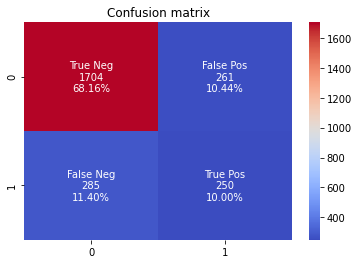

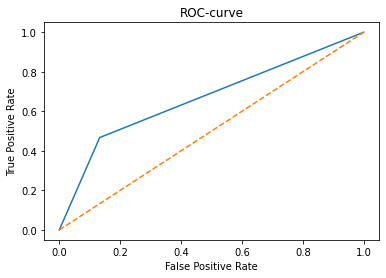

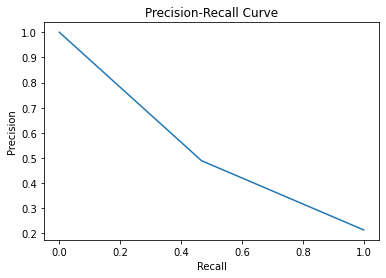

recall: [1.         0.46728972 0.        ]
precision: [0.214      0.48923679 1.        ]
f1: 0.47801147227533464
roc_auc: 0.6672326460726261
mse: 0.2184
rmse: 0.4673328578219169
r2: -0.2984233430833987
r2_: 0.7816
mae: 0.2184


In [14]:
cf_matrix(target_valid, model.predict(features_valid))

metric_lables = ('recall', 'precision', 'f1', 'roc_auc', 'mse', 'rmse', 'r2', 'r2_', 'mae')
metric_dict = dict(zip(metric_lables, metrics(target_valid, features_valid, 1, 1)))

for key in metric_dict.keys():
    print("%s: %s" % (key, metric_dict[key]))

Ложноположительные и  ложноотрицательные цели имеют довольно большую долю (12.24% и 11.08% соответственно). Модель не сильно отличается от случайной (площадь под кривой ROC модели равна 0.66).

Попробуем поднять порог и посмотрим, какими станут метрики.

In [15]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    predicted = model.predict(features)    
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f}".format(threshold, precision, recall))

Порог = 0.00 | Точность = 0.214 | Полнота = 1.000
Порог = 0.05 | Точность = 0.214 | Полнота = 1.000
Порог = 0.10 | Точность = 0.217 | Полнота = 0.998
Порог = 0.15 | Точность = 0.224 | Полнота = 0.991
Порог = 0.20 | Точность = 0.235 | Полнота = 0.972
Порог = 0.25 | Точность = 0.254 | Полнота = 0.938
Порог = 0.30 | Точность = 0.273 | Полнота = 0.910
Порог = 0.35 | Точность = 0.299 | Полнота = 0.884
Порог = 0.40 | Точность = 0.316 | Полнота = 0.822
Порог = 0.45 | Точность = 0.348 | Полнота = 0.770
Порог = 0.50 | Точность = 0.375 | Полнота = 0.686
Порог = 0.55 | Точность = 0.406 | Полнота = 0.615
Порог = 0.60 | Точность = 0.427 | Полнота = 0.533
Порог = 0.65 | Точность = 0.466 | Полнота = 0.465


Чем выше порог, тем выше точность, а полнота, наоорот, уменьшается. Продолжать поднимать порог нет смысла.

Попробуем увеличить `upsample` выборку для увеличения метрик. Для этого напишем соответствующую функцию и попробуем подобрать лучшее значение увеличения выборки с помощью функции `map`, ну и матрицу нарисуем :)

In [16]:
def upsampled(features, target, repeat, show_matrix, show_roc, show_pr):
    ''' Функция увеличения выборки для увеличения метрик качества'''    
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]
    
    # увеличение
    features_up = pd.concat([features_0] + [features_1] * repeat)
    target_up = pd.concat([target_0] + [target_1] * repeat)
    
    # перемешиваем
    features_up, target_up = shuffle(features_up, target_up, random_state=12345)  
    
    model = LogisticRegression(random_state=12345, solver = 'liblinear', class_weight='balanced')
    model.fit(features_up, target_up)
    recall_up, precision_up, f1_up, roc_auc_up, _, _, _, _, _ = metrics(target_up, features_up, show_roc, show_pr)
 
    # рисуем матрицу
    cf_matrix(target_up, model.predict(features_up)) if show_matrix == 1 else None    
    
    return recall_up, precision_up, f1_up, roc_auc_up, repeat+1

Увеличим выборку до 10 раз (проверим, какое значение увеличения оптимальное) и посмотрим на значения показателей.

In [17]:
N = 10
display('Recall: %g   Precision: %g   F1: %g   roc_auc: %g   best_repeat: %g' % 
                                                    max(map(upsampled, 
                                                            [features_train] * N, 
                                                            [target_train] * N, 
                                                            [i for i in range(1,N)],
                                                            [0] * N,
                                                            [0] * N,
                                                            [0] * N)))

'Recall: 0.684421   Precision: 0.836226   F1: 0.752746   roc_auc: 0.756775   best_repeat: 10'

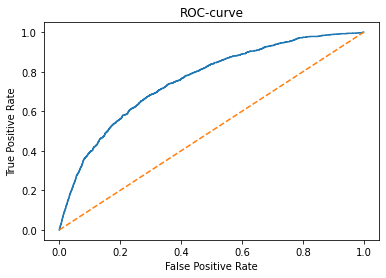

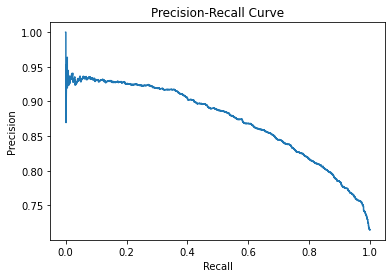

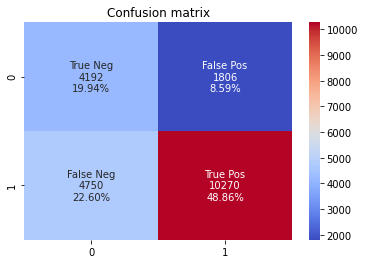

(array([1.00000000e+00, 9.99334221e-01, 9.99334221e-01, ...,
        6.65778961e-04, 6.65778961e-04, 0.00000000e+00]),
 array([0.71462556, 0.71448972, 0.71452373, ..., 0.90909091, 1.        ,
        1.        ]),
 0.7583357922691061,
 0.7567747837827877,
 11)

In [18]:
upsampled(features_train, target_train, 10, 1, 1, 1) # проверка

Увеличение выборки дает результаты: **f1-мера** порядка 0.75, а это довольно высокое значение.

## Тестирование модели

Проверим самую лучшую модель по итогам прошлого пункта (`случайный лес`) на обучающей выборке, делаем предсказание на валидационной выборке.

In [19]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 20, max_depth = 10, class_weight='balanced') 
model.fit(features_train, target_train) 

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=20,
                       random_state=12345)

`Обучающая выборка`

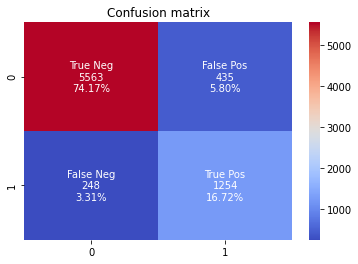

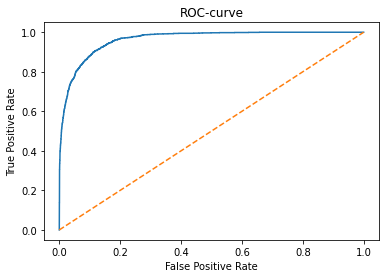

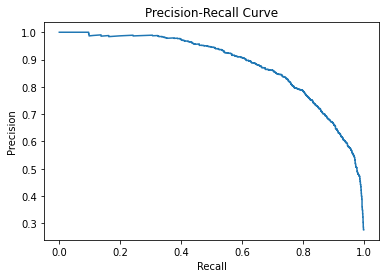

recall: [1.         0.99933422 0.99933422 ... 0.00599201 0.00532623 0.        ]
precision: [0.2756975  0.27556453 0.27561513 ... 1.         1.         1.        ]
f1: 0.7859605139454717
roc_auc: 0.9631895718457416
mse: 0.09106666666666667
rmse: 0.30177254127350067
r2: 0.43140167894402426
r2_: 0.9089333333333334
mae: 0.09106666666666667


In [20]:
cf_matrix(target_train, model.predict(features_train))

metric_lables = ('recall', 'precision', 'f1', 'roc_auc', 'mse', 'rmse', 'r2', 'r2_', 'mae')
metric_dict = dict(zip(metric_lables, metrics(target_train, features_train, 1, 1)))

for key in metric_dict.keys():
    print("%s: %s" % (key, metric_dict[key]))

`Валидационная выборка`

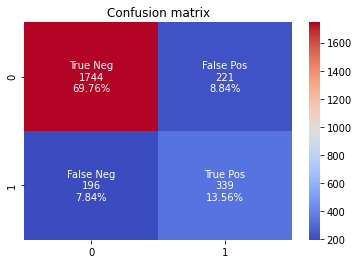

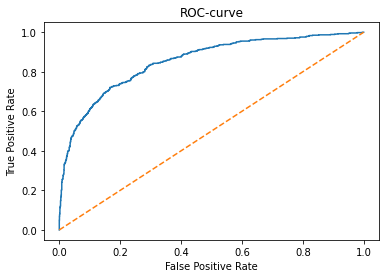

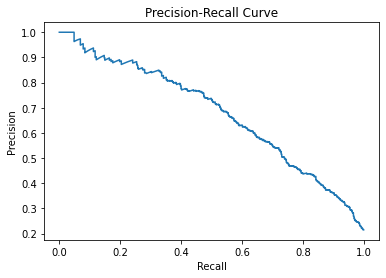

recall: [1.         0.99813084 0.99813084 ... 0.00373832 0.00186916 0.        ]
precision: [0.21477318 0.21445783 0.21454399 ... 1.         1.         1.        ]
f1: 0.6191780821917809
roc_auc: 0.8528667570331264
mse: 0.1668
rmse: 0.40841155713324273
r2: 0.008347007205536161
r2_: 0.8332
mae: 0.1668


In [21]:
cf_matrix(target_valid, model.predict(features_valid))

metric_lables = ('recall', 'precision', 'f1', 'roc_auc', 'mse', 'rmse', 'r2', 'r2_', 'mae')
metric_dict = dict(zip(metric_lables, metrics(target_valid, features_valid, 1, 1)))

for key in metric_dict.keys():
    print("%s: %s" % (key, metric_dict[key]))

В итоге мы добились неплохих результатов: 
- исследовали баланс классов,
- учли их дисбаланс,
- получили подтвержение качества модели, доказав это расчетом нужных метрик (f1-мера выше 0.59).

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*